**Fundamentals of Solar Cells and Photovoltaic Systems Engineering**

**Solutions Manual - Chapter 2**

**Problem 2.18**

**Using pvlib-python and retrieving data from PVGIS:**

**(a) Calculate the average annual global horizontal irradiation at Montpellier, France (43°36′39″ N, 3°52′38″ E), from both satellite and reanalysis datasets.**

**(b) Plot the interannual variability of annual global horizontal irradiation at the same location, from both satellite and reanalysis datasets.**


We start by importing several packages that will be useful, including [pandas](https://pandas.pydata.org/) and [matplotlib.pyplot](https://matplotlib.org/stable/index.html) to plot the results.

In [11]:
import requests
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd

We define a function to retrieve data from PVGIS.
More details regarding how to download data from PVGIS using an APi can be found in https://joint-research-centre.ec.europa.eu/pvgis-photovoltaic-geographical-information-system/getting-started-pvgis/api-non-interactive-service_en

In [12]:
def read_radiation_pvgis(raddatabase):
    params = {'lat': lat, 
              'lon': lon, 
              'browser': 1, 
              'outputformat': 'csv', 
              'raddatabase': raddatabase}
    
    series_file = Path(f'anual_series_{lat}_{lon}_{raddatabase}.csv')
    if not series_file.exists():
        resp_series = requests.get('https://re.jrc.ec.europa.eu/api/v5_2/seriescalc', params=params)
        with open(series_file, 'wb') as f:
            f.write(resp_series.content)
    
    series = pd.read_csv(series_file, 
                         skiprows=8, 
                         index_col='time', 
                         skipfooter=10, 
                         engine='python',
                         parse_dates=True, 
                         infer_datetime_format=True, 
                         date_parser=lambda x: dt.datetime.strptime(x, '%Y%m%d:%H%M'))
    
    series = series.rename({'G(i)': 'ghi'}, axis='columns')
    series['hour'] = series.index.hour
    series['date'] = series.index.date
    
    return series

We start by defining the location.

In [13]:
lat, lon = 43.6, 3.87 # Montpellier, France

We retrieve all the available data corresponding to the radiation database equal to satellite data (SARAH2) and calculate the average.

In [14]:
satellite = read_radiation_pvgis(raddatabase='PVGIS-SARAH2') 
num_years = len(satellite.index.year.unique())
print(f'{num_years} years of data available')
print(f'Average satellite anual irradiation = {round(satellite.ghi.sum()/1000 / num_years,1)} kWh/m2')

16 years of data available
Average satellite anual irradiation = 1577.5 kWh/m2


We retrieve all the available data corresponding to the radiation database equal to climate reanalysis data (ERA5) and calculate the average.

In [15]:
reanalysis = read_radiation_pvgis(raddatabase='PVGIS-ERA5')
num_years = len(reanalysis.index.year.unique())
print(f'{num_years} years of data available')
print(f'Average reanalysis anual irradiation = {round(reanalysis.ghi.sum()/1000 / num_years,1)} kWh/m2')

16 years of data available
Average reanalysis anual irradiation = 1601.1 kWh/m2


We calculate the annual values for the two data sources.

In [22]:
satellite.resample('Y').sum()/1000

,ghi,H_sun,T2m,WS10m,Int,hour
time,,,,,,
2005-12-31,1560.01627,128.03107,127.37213,39.25466,0.0,100.740
2006-12-31,1607.89395,128.07220,136.33286,37.31148,0.0,100.740
2007-12-31,1585.44673,128.35433,130.76191,46.70577,0.0,100.740
2008-12-31,1482.46071,126.10470,130.13264,38.87815,0.0,101.016
2009-12-31,1569.51581,125.22906,135.90398,37.50141,0.0,100.740
2010-12-31,1557.54188,128.31115,125.53143,40.65826,0.0,100.740
2011-12-31,1595.16585,127.94245,136.48892,36.36240,0.0,100.740
2012-12-31,1591.65597,128.45416,132.48546,38.42720,0.0,101.016
2013-12-31,1548.87295,127.83851,128.37378,39.69918,0.0,100.740


In [23]:
satellite_year = satellite.resample('Y').sum() /1000 # kWh
reanalysis_year = reanalysis.resample('Y').sum() /1000 # kWh

And plot them. 

([<matplotlib.axis.XTick at 0x1ff606ba208>,
 [Text(1, 0, 'Satellite'), Text(2, 0, 'Reanalysis')])

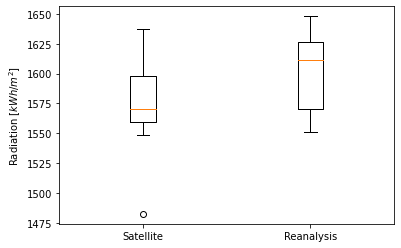

In [25]:
plt.boxplot([satellite_year['ghi'], reanalysis_year['ghi']])
plt.ylabel('Radiation [$kWh/m^2$]')
plt.xticks([1, 2], ['Satellite', 'Reanalysis'])

We can also plot a colormap showing the hourly values throughout the year. 

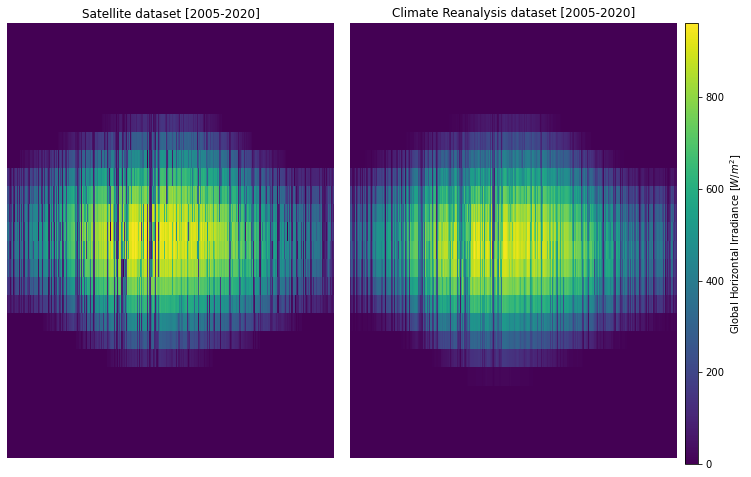

In [27]:
#%% 1-year satellite vs reanalysis
YEAR = 2010

satellite_1year = satellite[satellite.index.year == YEAR]
reanalysis_1year = reanalysis[reanalysis.index.year == YEAR]

fig, (ax_satellite_1year, ax_reanalysis_1year) = plt.subplots(nrows=1, 
                                                              ncols=2, 
                                                              figsize=(12, 8), 
                                                              sharey=True, 
                                                              squeeze=True)
plt.subplots_adjust(wspace=0.05)

im = ax_satellite_1year.pcolormesh(satellite_1year.pivot_table(values='ghi', 
                                                               index='hour', 
                                                               columns='date', 
                                                               fill_value=0))
ax_satellite_1year.axis('off')
ax_satellite_1year.set_title('Satellite dataset [2005-2020]')
im = ax_reanalysis_1year.pcolormesh(reanalysis_1year.pivot_table(values='ghi', 
                                                                 index='hour', 
                                                                 columns='date', 
                                                                 fill_value=0))
ax_reanalysis_1year.axis('off')
ax_reanalysis_1year.set_title('Climate Reanalysis dataset [2005-2020]')
cbar_ax = fig.add_axes([0.91, 0.115, 0.015, 0.765])
fig.colorbar(im, cax=cbar_ax, label='Global Horizontal Irradiance [$W/m^2$]')

We can also calculate the normalized standard deviation for the annual global horizontal irradiance.

In [37]:
satellite_mean = satellite_year['ghi'].mean()
satellite_std_n = 100*satellite_year['ghi'].std()/satellite_year['ghi'].mean()

print(f'Average satellite anual irradiation = {round(satellite_mean)} kWh/m2')
print(f'Normalized standard deviation for satellite anual irradiation = {round(satellite_std_n,1)} %')

Average satellite anual irradiation = 1577 kWh/m2
Normalized standard deviation for satellite anual irradiation = 2.3 %


In [36]:
reanalysis_mean = reanalysis_year['ghi'].mean()
reanalysis_std_n = 100*reanalysis_year['ghi'].std()/reanalysis_year['ghi'].mean()

print(f'Average reanalysis anual irradiation = {round(reanalysis_mean)} kWh/m2')
print(f'Normalized standard deviation for reanalysis anual irradiation = {round(reanalysis_std_n,1)} %')

Average reanalysis anual irradiation = 1601 kWh/m2
Normalized standard deviation for reanalysis anual irradiation = 2.0 %
